# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        n, d = X.shape
        # Инициализация весов: если начальные веса не заданы, используем нулевой вектор
        if self.w0 is None:
            self.w = np.zeros(d)
        else:
            self.w = self.w0.copy()
        
        # Сохраняем начальное значение функции потерь
        loss = self.calc_loss(X, y)
        self.loss_history.append(loss)
        
        for i in range(self.max_iter):
            old_w = self.w.copy()
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
                self.w = self.w - self.eta * grad
            elif self.gd_type == 'stochastic':
                # Выбираем случайный пример
                idx = np.random.randint(n)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
                self.w = self.w - self.eta * grad
            else:
                raise ValueError("Invalid gd_type. Choose 'full' or 'stochastic'.")
            
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            # Проверка критерия останова по норме разницы весов
            if np.linalg.norm(self.w - old_w) < self.tolerance:
                break
                
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        logits = np.dot(X, self.w)
        p = 1 / (1 + np.exp(-logits))
        # Возвращаем вероятности в виде двух столбцов:
        # первый столбец - вероятность класса 0, второй - класса 1
        return np.vstack([1 - p, p]).T


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        logits = np.dot(X, self.w)
        p = 1 / (1 + np.exp(-logits))
        n = X.shape[0]
        grad = np.dot(X.T, (p - y)) / n
        return grad


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        logits = np.dot(X, self.w)
        p = 1 / (1 + np.exp(-logits))
        # Добавляем маленькое число epsilon для избежания логарифма нуля
        epsilon = 1e-15
        loss = - np.mean(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

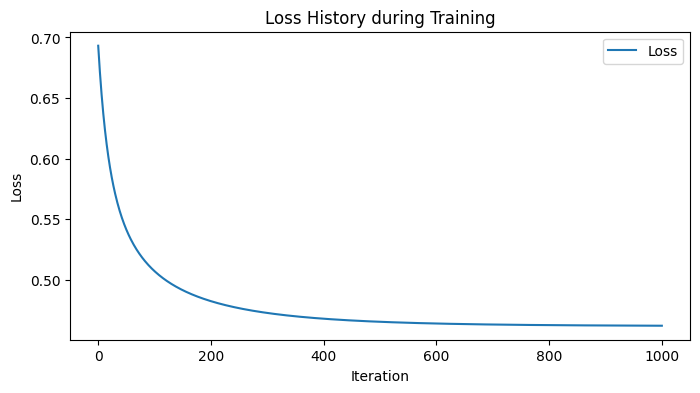

In [5]:
# your code
model = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=1000, eta=1e-2)
model.fit(X_train, y_train)

# Построим график изменения лосса во время обучения
plt.figure(figsize=(8, 4))
plt.plot(model.loss_history, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss History during Training")
plt.legend()
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

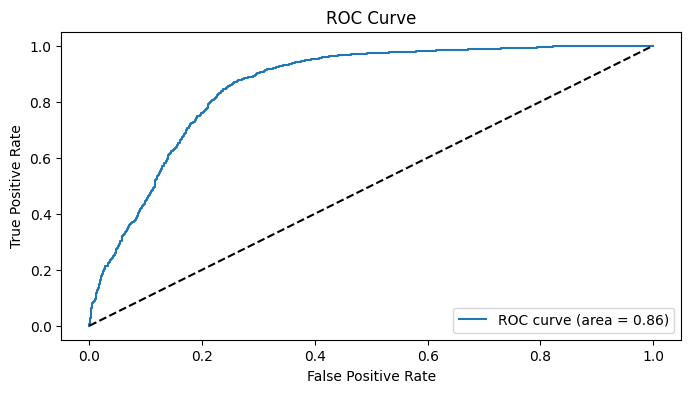

In [6]:
# your code

# Получим предсказанные вероятности для положительного класса на тестовой выборке
y_proba = model.predict_proba(X_test)[:, 1]

# Рассчитаем ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Получим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [7]:
# your code

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

kf = KFold(n_splits=5, shuffle=True, random_state=999)
roc_aucs = []
pr_aucs = []

for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]
    
    # Создаем и обучаем модель на текущем fold
    model_cv = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=1000, eta=1e-2)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Получаем вероятности для положительного класса на валидационном наборе
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]
    
    # Вычисляем ROC-AUC
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)
    
    # Вычисляем Precision-Recall кривую и PR-AUC
    precision, recall, _ = precision_recall_curve(y_val_cv, y_proba_cv)
    pr_auc = auc(recall, precision)
    
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)

mean_roc_auc = np.mean(roc_aucs)
mean_pr_auc = np.mean(pr_aucs)

print("Mean ROC-AUC:", mean_roc_auc)
print("Mean PR-AUC:", mean_pr_auc)

Mean ROC-AUC: 0.8608631830037348
Mean PR-AUC: 0.8321620602517299


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [8]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [12]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
# data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

--2025-03-15 16:50:43--  https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_140329/2464913690.py:2: SyntaxWarning: invalid escape sequence '\s'
  data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘boston_house_prices.csv’

boston_house_prices     [  <=>               ] 291,74K   825KB/s    in 0,4s    

2025-03-15 16:50:44 (825 KB/s) - ‘boston_house_prices.csv’ saved [298746]

--2025-03-15 16:50:44--  https://github.githubassets.com/
Resolving github.githubassets.com (github.githubassets.com)... 185.199.111.154, 185.199.110.154, 185.199.108.154, ...
Connecting to github.githubassets.com (github.githubassets.com)|185.199.111.154|:443... connected.
HTTP request sent, awaiting response... 404 The requested content does not exist.
2025-03-15 16:50:44 ERROR 404: The requested content does not exist..

--2025-03-15 16:50:44--  https://avatars.githubusercontent.com/
Resolving avatars.githubusercontent.com (avatars.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to avatars.githubusercontent.com (avatars.githubusercontent.com)|185.199.110.133|:443... conne

/tmp/ipykernel_140329/2464913690.py:2: SyntaxWarning: invalid escape sequence '\s'
  data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

KeyboardInterrupt



**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [9]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2535143/16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [10]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [11]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [12]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code
    if len(R) == 0:
        return 0.0
    # Используем дисперсию (variance) целевой переменной (последний столбец)
    return np.var(R[:, -1])


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    # Определяем индекс столбца по имени признака
    idx = feature_names.index(feature)
    left_mask = R_m[:, idx] <= t
    right_mask = R_m[:, idx] > t
    R_left = R_m[left_mask]
    R_right = R_m[right_mask]
    return R_left, R_right


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
    R_left, R_right = split_node(R_m, feature, t)
    n_total = len(R_m)
    q = (len(R_left) / n_total) * H(R_left) + (len(R_right) / n_total) * H(R_right)
    return q

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

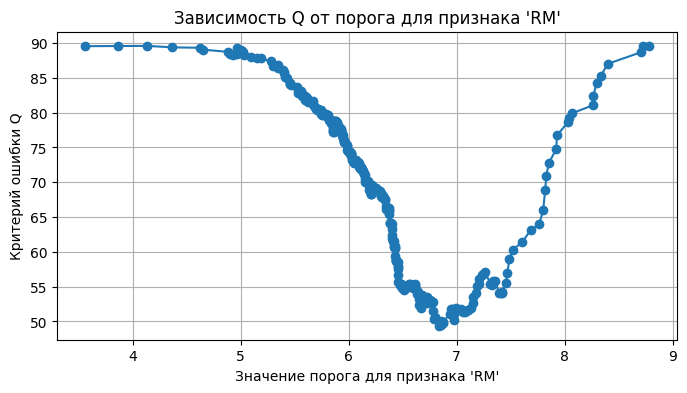

In [13]:
# your code
import matplotlib.pyplot as plt
import numpy as np

# Выбираем признак для разбиения, например "RM" (среднее число комнат)
feature = "RM"

# Преобразуем обучающую выборку в numpy-массив, где последний столбец – целевая переменная
R_m = X_train.to_numpy()

# Получаем уникальные значения для выбранного признака (пороги разбиения)
thresholds = np.sort(X_train[feature].unique())

# Вычисляем критерий ошибки для каждого порога
q_values = []
for t in thresholds:
    q = q_error(R_m, feature, t)
    q_values.append(q)

# Строим график зависимости критерия ошибки от порога
plt.figure(figsize=(8, 4))
plt.plot(thresholds, q_values, marker='o')
plt.xlabel(f"Значение порога для признака '{feature}'")
plt.ylabel("Критерий ошибки Q")
plt.title(f"Зависимость Q от порога для признака '{feature}'")
plt.grid(True)
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [14]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    # Определяем индекс признака по глобальной переменной feature_names
    idx = feature_names.index(feature)
    # Получаем все уникальные значения признака (кандидаты для порога) и сортируем их
    candidate_thresholds = np.sort(np.unique(R_m[:, idx]))
    
    q_values = []
    for t in candidate_thresholds:
        q = q_error(R_m, feature, t)
        q_values.append(q)
    
    # Находим индекс минимального значения Q
    min_index = np.argmin(q_values)
    optimal_threshold = candidate_thresholds[min_index]
    
    return optimal_threshold, q_values

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Лучший признак для разбиения: RM
Оптимальный порог разбиения: 6.833
Минимальное значение критерия ошибки Q: 49.380895003620026


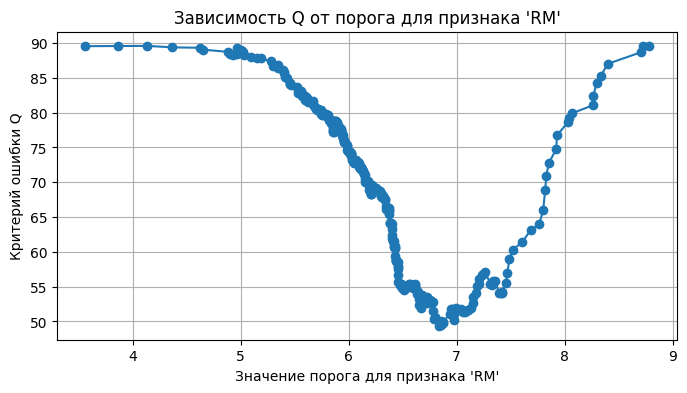

In [15]:
# your code
import matplotlib.pyplot as plt
import numpy as np

# Преобразуем обучающую выборку в numpy-массив (предполагается, что последний столбец – целевая переменная)
R_m = X_train.to_numpy()

best_feature = None
best_threshold = None
best_q = np.inf
best_q_values = None
best_candidate_thresholds = None

# Перебираем все признаки из списка feature_names
for feature in feature_names:
    # Получаем оптимальный порог и список Q для всех кандидатов для данного признака
    opt_threshold, q_vals = get_optimal_split(R_m, feature)
    # Для построения графика получим все уникальные значения признака
    idx = feature_names.index(feature)
    candidate_thresholds = np.sort(np.unique(R_m[:, idx]))
    # Минимальное значение критерия ошибки для текущего признака
    min_q = np.min(q_vals)
    
    # Если найденное минимальное значение меньше, чем лучшее найденное ранее, обновляем лучшие параметры
    if min_q < best_q:
        best_q = min_q
        best_feature = feature
        best_threshold = opt_threshold
        best_q_values = q_vals
        best_candidate_thresholds = candidate_thresholds

print("Лучший признак для разбиения:", best_feature)
print("Оптимальный порог разбиения:", best_threshold)
print("Минимальное значение критерия ошибки Q:", best_q)

# Строим график зависимости критерия ошибки от значения порога для найденного признака
plt.figure(figsize=(8, 4))
plt.plot(best_candidate_thresholds, best_q_values, marker='o')
plt.xlabel(f"Значение порога для признака '{best_feature}'")
plt.ylabel("Критерий ошибки Q")
plt.title(f"Зависимость Q от порога для признака '{best_feature}'")
plt.grid(True)
plt.show()

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

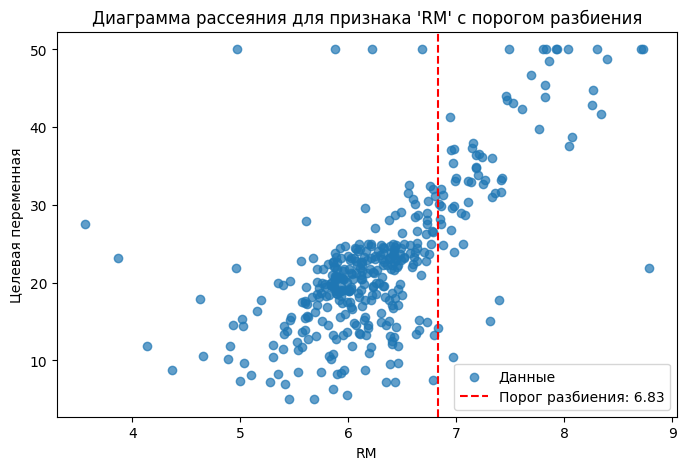

In [16]:
# your code
plt.figure(figsize=(8, 5))
plt.scatter(X_train[best_feature], X_train['target'], alpha=0.7, label='Данные')
plt.axvline(x=best_threshold, color='red', linestyle='--', 
            label=f'Порог разбиения: {best_threshold:.2f}')
plt.xlabel(best_feature)
plt.ylabel("Целевая переменная")
plt.title(f"Диаграмма рассеяния для признака '{best_feature}' с порогом разбиения")
plt.legend()
plt.show()